In [7]:
import os
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold
import winsound as sd

In [2]:
from PIL import Image
import numpy as np

dataset=[]
#train_dataset=[]
#test_dataset=[]
for n in range(1,141):
  try:
    image = Image.open('Dataset/o_{}.png'.format(n)).convert('L')
  except:
    image = Image.open('Dataset/o_{}.jpg'.format(n)).convert('L')
  image = np.array(image)
  image =torch.FloatTensor([image])
  #data=image,torch.FloatTensor([[0,1]])
  data=image,0
  dataset.append(data)
  try:
    image = Image.open('Dataset/x_{}.png'.format(n)).convert('L')
  except:
    image = Image.open('Dataset/x_{}.jpg'.format(n)).convert('L')
  image = np.array(image)
  image=torch.FloatTensor([image])
  #data=image,torch.FloatTensor([[1,0]])
  data=image,1
  dataset.append(data)

C:\Users\KimHojin\AppData\Local\Temp\ipykernel_11424\2429053110.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_8f7uhuge1i\croot\pytorch-select_1717607507421\work\torch\csrc\utils\tensor_new.cpp:277.)
  image =torch.FloatTensor([image])


--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=82944, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=2, bias=True)
Starting epoch 1
Loss after mini-batch    10: 47.748
Loss after mini-batch    20: 22.173
Loss after mini-batch    30: 7.246
Loss after mini-batch    40: 6.557
Loss after mini-batch    50: 6.419
Loss after mini-batch    60: 4.663
Loss after mini-batch    70: 5.524
Loss aft

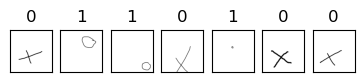

Accuracy for fold 0: 87 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 87.5 %
Average: 87.5 %


In [29]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3,padding=1), # 1*300*300 -> 10*300*300
      nn.ReLU(),
      nn.MaxPool2d((2,2)), #10*300*300 -> 10*150*150
      #풀링 추가
      nn.Conv2d(32, 64, kernel_size=3), #10*150*150 -> 20*148*148
      nn.ReLU(),
      nn.MaxPool2d((2,2)), #20*148*148 -> 20*74*74
      #풀링 추가
      nn.Conv2d(64, 128, kernel_size=3), #20*74*74->40*72*72
      nn.ReLU(),
      nn.MaxPool2d((2,2)), #40*72*72->40*36,36
      #풀링 추가
      nn.Conv2d(128, 256, kernel_size=3,padding=1), #40*36*36 -> 80*18*18
      nn.ReLU(),
      nn.MaxPool2d((2,2)), #80*33*33->80*16*16
      #풀링 추가
      nn.Flatten(),
      nn.Linear(18 * 18 * 256, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 2)
    )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)


if __name__ == '__main__':

  # Configuration options
  k_folds = 5
  num_epochs = 10
  loss_function = nn.CrossEntropyLoss()

  # For fold results
  results = {}

  # Set fixed random number seed
  torch.manual_seed(42)

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)

  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=train_subsampler)
    trainloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    # Init the neural network
    network = SimpleConvNet()
    network.apply(reset_weights)

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data
        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 9:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 1))
            current_loss = 0.0

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./last_model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)
    
    # Evaluationfor this fold
    correct, total = 0, 0
    c=0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        cnt=-1
        for a in inputs:
            cnt+=1
            if predicted[cnt] == targets[cnt]:
                continue
            c+=1
            plt.subplot(2,10,c)
            plt.imshow(a[0, :, :].numpy(), cmap='gray')
            plt.title(str(predicted[cnt].item()))
            plt.xticks([], [])
            plt.yticks([], []) 
      plt.show()
      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
    break
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')
def beepsound():
    fr = 2000    # range : 37 ~ 32767
    du = 1000     # 1000 ms ==1second
    sd.Beep(fr, du) # winsound.Beep(frequency, duration)
beepsound()

In [28]:
model_state_dict = torch.load('./last_model-fold-0.pth')
network.load_state_dict(model_state_dict)

correct, total = 0, 0
c=0
with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        cnt=-1
        for a in inputs:
            cnt+=1
            if predicted[cnt] == targets[cnt]:
                continue
            c+=1
            plt.subplot(2,5,c)
            plt.imshow(a[0, :, :].numpy(), cmap='gray')
            plt.title(str(predicted[cnt].item()))
            plt.xticks([], [])
            plt.yticks([], [])
            
    plt.show()
    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

Accuracy for fold 2: 100 %
--------------------------------


--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=82944, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=2, bias=True)
Starting epoch 1
Training loss: 0.658, accuracy: 72.77%
Validation loss: 0.436, accuracy: 80.36%
Starting epoch 2
Training loss: 0.269, accuracy: 86.61%
Validation loss: 0.286, accuracy: 85.71%
Starting epoch 3
Training loss: 0.100, accuracy: 95.54%
Validation loss: 0.292

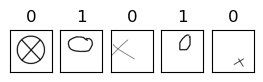

Accuracy for fold 0: 91 %
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=82944, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=2, bias=True)
Starting epoch 1
Training loss: 0.863, accuracy: 66.07%
Validation loss: 0.441, accuracy: 82.14%
Starting epoch 2
Training loss: 0.388, accuracy: 81.25%
Validation loss: 0.365, accuracy: 80.36%
Starting epoch 3
Training loss: 0.177, accuracy: 91.

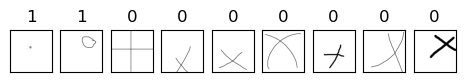

Accuracy for fold 1: 83 %
--------------------------------
FOLD 2
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=82944, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=2, bias=True)
Starting epoch 1
Training loss: 0.873, accuracy: 63.39%
Validation loss: 0.546, accuracy: 66.07%
Starting epoch 2
Training loss: 0.339, accuracy: 84.38%
Validation loss: 0.359, accuracy: 82.14%
Starting epoch 3
Training loss: 0.158, accuracy: 92.

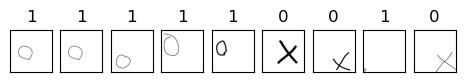

Accuracy for fold 2: 83 %
--------------------------------
FOLD 3
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=82944, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=2, bias=True)
Starting epoch 1
Training loss: 0.894, accuracy: 71.43%
Validation loss: 0.484, accuracy: 78.57%
Starting epoch 2
Training loss: 0.305, accuracy: 87.95%
Validation loss: 0.465, accuracy: 80.36%
Starting epoch 3
Training loss: 0.157, accuracy: 94.

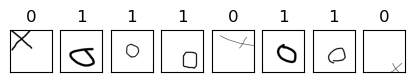

Accuracy for fold 3: 85 %
--------------------------------
FOLD 4
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Reset trainable parameters of layer = Linear(in_features=82944, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=2, bias=True)
Starting epoch 1
Training loss: 0.761, accuracy: 69.20%
Validation loss: 0.399, accuracy: 83.93%
Starting epoch 2
Training loss: 0.406, accuracy: 83.48%
Validation loss: 0.359, accuracy: 78.57%
Starting epoch 3
Training loss: 0.234, accuracy: 90.

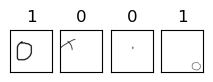

Accuracy for fold 4: 92 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 91.07142857142857 %
Fold 1: 83.92857142857143 %
Fold 2: 83.92857142857143 %
Fold 3: 85.71428571428571 %
Fold 4: 92.85714285714286 %
Average: 87.5 %


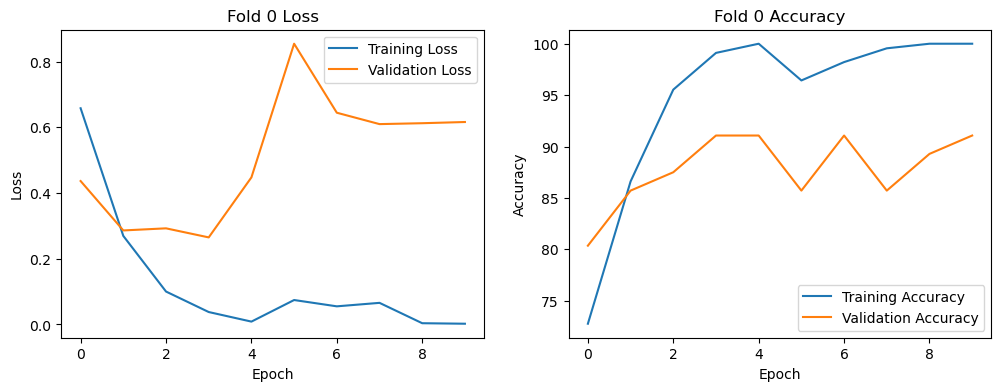

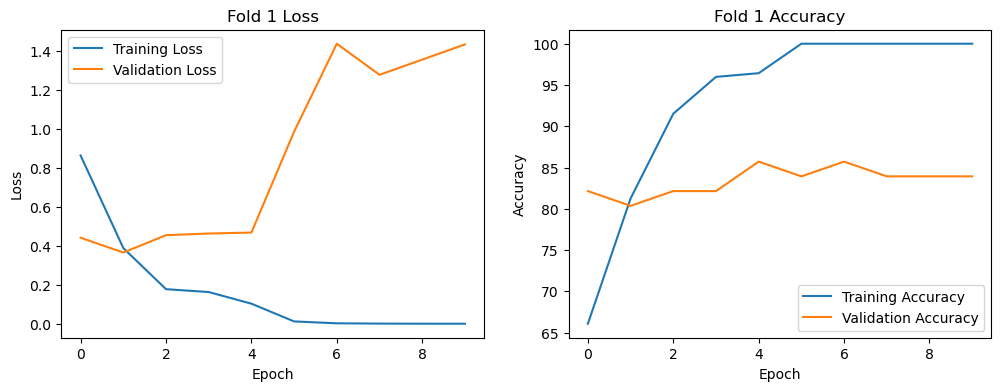

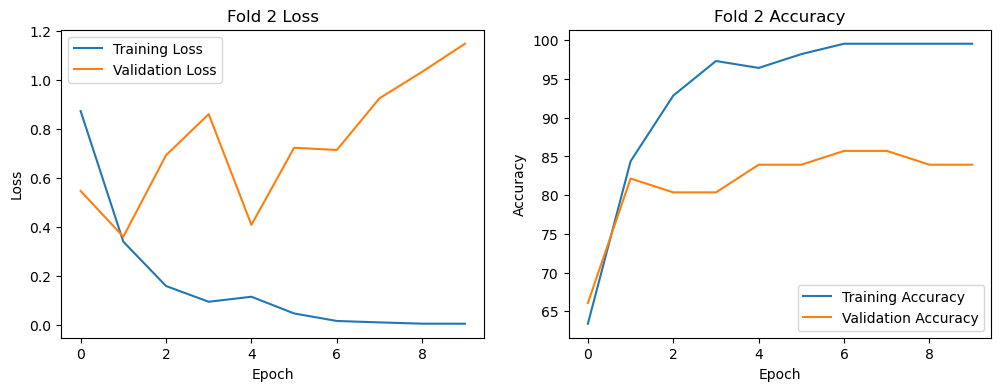

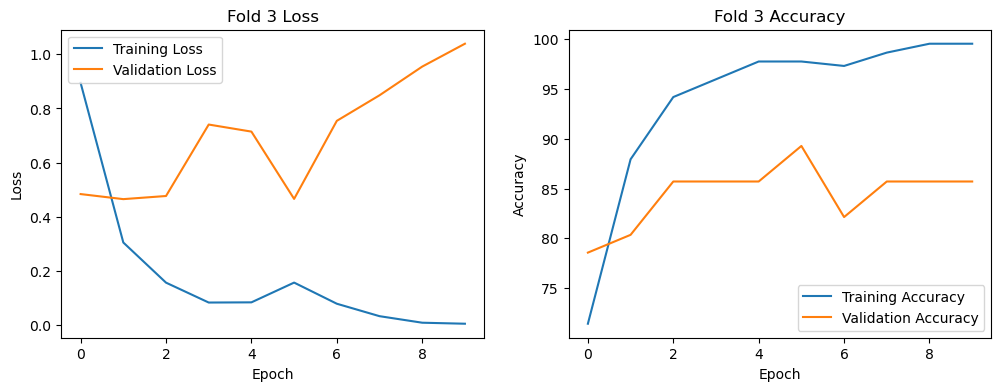

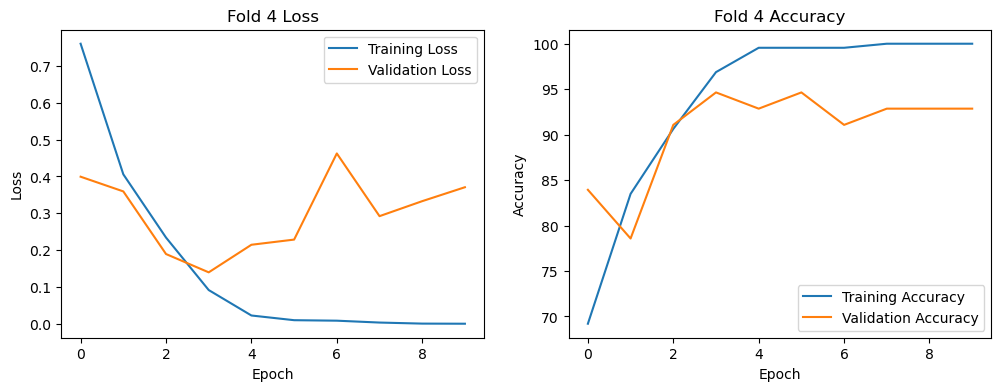

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Define the reset_weights function
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# Define the SimpleConvNet class
class SimpleConvNet(nn.Module):
    '''
    Simple Convolutional Neural Network
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,padding=1), # 1*300*300 -> 10*300*300
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #10*300*300 -> 10*150*150
            #풀링 추가
            nn.Conv2d(32, 64, kernel_size=3), #10*150*150 -> 20*148*148
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #20*148*148 -> 20*74*74
            #풀링 추가
            nn.Conv2d(64, 128, kernel_size=3), #20*74*74->40*72*72
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #40*72*72->40*36,36
            #풀링 추가
            nn.Conv2d(128, 256, kernel_size=3,padding=1), #40*36*36 -> 80*18*18
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #80*33*33->80*16*16
            nn.Flatten(),
            nn.Linear(18 * 18 * 256, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

if __name__ == '__main__':
    # Configuration options
    k_folds = 5
    num_epochs = 10
    loss_function = nn.CrossEntropyLoss()

    # For fold results
    results = {}

    # Lists to store metrics
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    # Set fixed random number seed
    torch.manual_seed(42)

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Start print
    print('--------------------------------')

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = DataLoader(dataset, batch_size=1, sampler=train_subsampler)
        testloader = DataLoader(dataset, batch_size=1, sampler=test_subsampler)

        # Init the neural network
        network = SimpleConvNet()
        network.apply(reset_weights)

        # Initialize optimizer
        optimizer = optim.Adam(network.parameters(), lr=1e-4)

        # Metrics for this fold
        fold_train_loss = []
        fold_val_loss = []
        fold_train_acc = []
        fold_val_acc = []

        # Run the training loop for defined number of epochs
        for epoch in range(num_epochs):
            # Print epoch
            print(f'Starting epoch {epoch+1}')

            # Set current loss value
            current_train_loss = 0.0
            correct_train, total_train = 0, 0

            # Iterate over the DataLoader for training data
            network.train()
            for i, data in enumerate(trainloader, 0):
                # Get inputs
                inputs, targets = data
                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)

                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()

                # Print statistics
                current_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()

            # Compute training loss and accuracy
            train_loss = current_train_loss / len(trainloader)
            train_accuracy = 100.0 * correct_train / total_train
            fold_train_loss.append(train_loss)
            fold_train_acc.append(train_accuracy)
            print(f'Training loss: {train_loss:.3f}, accuracy: {train_accuracy:.2f}%')

            # Validation phase
            network.eval()
            current_val_loss = 0.0
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for data in testloader:
                    inputs, targets = data
                    outputs = network(inputs)
                    loss = loss_function(outputs, targets)
                    current_val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += targets.size(0)
                    correct_val += (predicted == targets).sum().item()

            # Compute validation loss and accuracy
            val_loss = current_val_loss / len(testloader)
            val_accuracy = 100.0 * correct_val / total_val
            fold_val_loss.append(val_loss)
            fold_val_acc.append(val_accuracy)
            print(f'Validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')

        # Append fold metrics to the main lists
        train_loss_history.append(fold_train_loss)
        val_loss_history.append(fold_val_loss)
        train_accuracy_history.append(fold_train_acc)
        val_accuracy_history.append(fold_val_acc)

        # Process is complete.
        print('Training process has finished. Saving trained model.')

        # Print about testing
        print('Starting testing')

        # Saving the model
        save_path = f'./last_model-fold-{fold}.pth'
        torch.save(network.state_dict(), save_path)

        # Evaluation for this fold
        correct, total = 0, 0
        c = 0
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                # Generate outputs
                outputs = network(inputs)
                # Set total and correct
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                cnt = -1
                for a in inputs:
                    cnt += 1
                    if predicted[cnt] == targets[cnt]:
                        continue
                    c += 1
                    plt.subplot(2, 10, c)
                    plt.imshow(a[0, :, :].numpy(), cmap='gray')
                    plt.title(str(predicted[cnt].item()))
                    plt.xticks([], [])
                    plt.yticks([], [])
            plt.show()
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum_acc = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum_acc += value
    print(f'Average: {sum_acc/len(results.items())} %')

    # Plot the metrics
    for fold in range(k_folds):
        plt.figure(figsize=(12, 4))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history[fold], label='Training Loss')
        plt.plot(val_loss_history[fold], label='Validation Loss')
        plt.title(f'Fold {fold} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_history[fold], label='Training Accuracy')
        plt.plot(val_accuracy_history[fold], label='Validation Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 3
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
------------------------

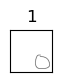

--------------------------------
FOLD 20
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 21
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 22
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 23
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------

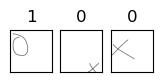

--------------------------------
FOLD 40
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 41
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 42
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 43
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------

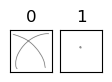

--------------------------------
FOLD 60
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 61
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 62
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 63
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------

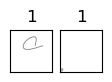

--------------------------------
FOLD 80
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 81
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 82
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 83
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------

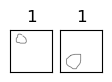

--------------------------------
FOLD 100
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 101
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 102
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 103
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

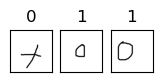

--------------------------------
FOLD 120
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 121
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 122
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 123
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

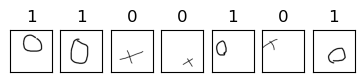

--------------------------------
FOLD 140
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 141
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 142
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 143
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

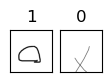

--------------------------------
FOLD 160
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 161
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 162
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 163
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

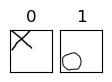

--------------------------------
FOLD 180
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 181
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 182
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 183
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

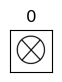

--------------------------------
FOLD 200
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 201
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 202
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 203
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

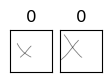

--------------------------------
FOLD 220
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 221
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 222
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 223
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

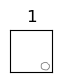

--------------------------------
FOLD 240
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 241
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 242
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
--------------------------------
FOLD 243
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
----------------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Define the reset_weights function
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# Define the SimpleConvNet class
class SimpleConvNet(nn.Module):
    '''
    Simple Convolutional Neural Network
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,padding=1), # 1*300*300 -> 10*300*300
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #10*300*300 -> 10*150*150
            #풀링 추가
            nn.Conv2d(32, 64, kernel_size=3), #10*150*150 -> 20*148*148
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #20*148*148 -> 20*74*74
            #풀링 추가
            nn.Conv2d(64, 128, kernel_size=3), #20*74*74->40*72*72
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #40*72*72->40*36,36
            #풀링 추가
            nn.Conv2d(128, 256, kernel_size=3,padding=1), #40*36*36 -> 80*18*18
            nn.ReLU(),
            nn.MaxPool2d((2,2)), #80*33*33->80*16*16
            nn.Flatten(),
            nn.Linear(18 * 18 * 256, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

if __name__ == '__main__':
    # Configuration options
    k_folds = 280
    num_epochs = 10
    loss_function = nn.CrossEntropyLoss()

    # For fold results
    results = {}

    # Lists to store metrics
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    # Set fixed random number seed
    torch.manual_seed(42)

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=False)

    # Start print
    print('--------------------------------')

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = DataLoader(dataset, batch_size=1, sampler=train_subsampler)
        testloader = DataLoader(dataset, batch_size=1, sampler=test_subsampler)

        # Init the neural network
        network = SimpleConvNet()
        network.apply(reset_weights)

        # Initialize optimizer
        optimizer = optim.Adam(network.parameters(), lr=1e-4)

        # Metrics for this fold
        fold_train_loss = []
        fold_val_loss = []
        fold_train_acc = []
        fold_val_acc = []

        # Run the training loop for defined number of epochs
        for epoch in range(num_epochs):
            # Print epoch
            print(f'Starting epoch {epoch+1}')

            # Set current loss value
            current_train_loss = 0.0
            correct_train, total_train = 0, 0

            # Iterate over the DataLoader for training data
            network.train()
            for i, data in enumerate(trainloader, 0):
                # Get inputs
                inputs, targets = data
                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)

                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()

                # Print statistics
                current_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()

            # Compute training loss and accuracy
            train_loss = current_train_loss / len(trainloader)
            train_accuracy = 100.0 * correct_train / total_train
            fold_train_loss.append(train_loss)
            fold_train_acc.append(train_accuracy)
            #print(f'Training loss: {train_loss:.3f}, accuracy: {train_accuracy:.2f}%')

            # Validation phase
            network.eval()
            current_val_loss = 0.0
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for data in testloader:
                    inputs, targets = data
                    outputs = network(inputs)
                    loss = loss_function(outputs, targets)
                    current_val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += targets.size(0)
                    correct_val += (predicted == targets).sum().item()

            # Compute validation loss and accuracy
            val_loss = current_val_loss / len(testloader)
            val_accuracy = 100.0 * correct_val / total_val
            fold_val_loss.append(val_loss)
            fold_val_acc.append(val_accuracy)
            #print(f'Validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')

        # Append fold metrics to the main lists
        train_loss_history.append(fold_train_loss)
        val_loss_history.append(fold_val_loss)
        train_accuracy_history.append(fold_train_acc)
        val_accuracy_history.append(fold_val_acc)

        # Process is complete.
        #print('Training process has finished. Saving trained model.')

        # Print about testing
        #print('Starting testing')

        # Saving the model
        save_path = f'./loocv/last_model-LOOCV-{fold}.pth'
        torch.save(network.state_dict(), save_path)

        # Evaluation for this fold
        correct, total = 0, 0
        if fold%20==19:
            c = 0
        with torch.no_grad():
            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                # Generate outputs
                outputs = network(inputs)
                # Set total and correct
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                cnt = -1
                for a in inputs:
                    cnt += 1
                    if predicted[cnt] == targets[cnt]:
                        continue
                    c += 1
                    plt.subplot(2, 10, c)
                    plt.imshow(a[0, :, :].numpy(), cmap='gray')
                    plt.title(str(predicted[cnt].item()))
                    plt.xticks([], [])
                    plt.yticks([], [])
            if fold%20==19:
                plt.show()
        # Print accuracy
        #print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')

    # Plot the metrics
    for fold in range(k_folds):
        plt.figure(figsize=(12, 4))
        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history[fold], label='Training Loss')
        plt.plot(val_loss_history[fold], label='Validation Loss')
        plt.title(f'Fold {fold} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_history[fold], label='Training Accuracy')
        plt.plot(val_accuracy_history[fold], label='Validation Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()
